## Task 1

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops

(np.float64(-0.5), np.float64(1023.5), np.float64(1535.5), np.float64(-0.5))

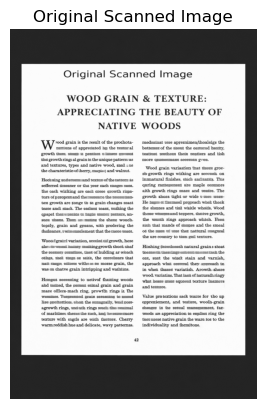

In [2]:
img = cv2.imread( r"C:\Users\11suj\Downloads\ChatGPT Image Feb 3, 2026, 12_19_46 AM.png" , cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap="gray")
plt.title("Original Scanned Image")
plt.axis("off")

(np.float64(-0.5), np.float64(1023.5), np.float64(1535.5), np.float64(-0.5))

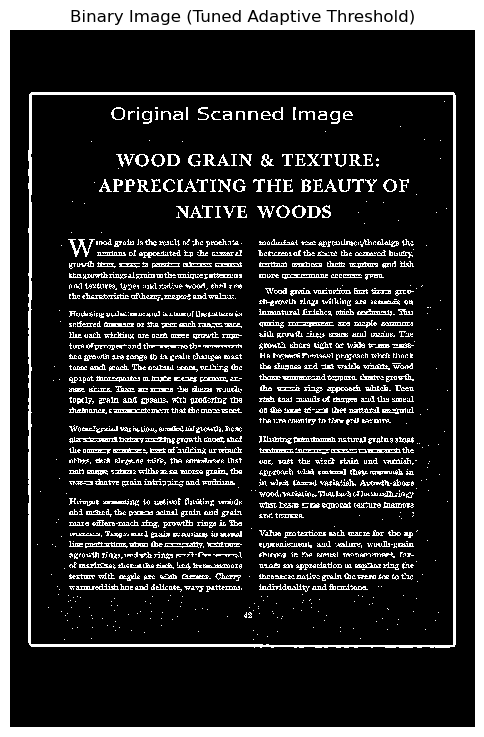

In [3]:
binary = cv2.adaptiveThreshold(
    img,
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV,
    blockSize=21,
    C=5
)

plt.figure(figsize=(6,10))
plt.imshow(binary, cmap="gray", interpolation="nearest")
plt.title("Binary Image (Tuned Adaptive Threshold)")
plt.axis("off")

(np.float64(-0.5), np.float64(1023.5), np.float64(1535.5), np.float64(-0.5))

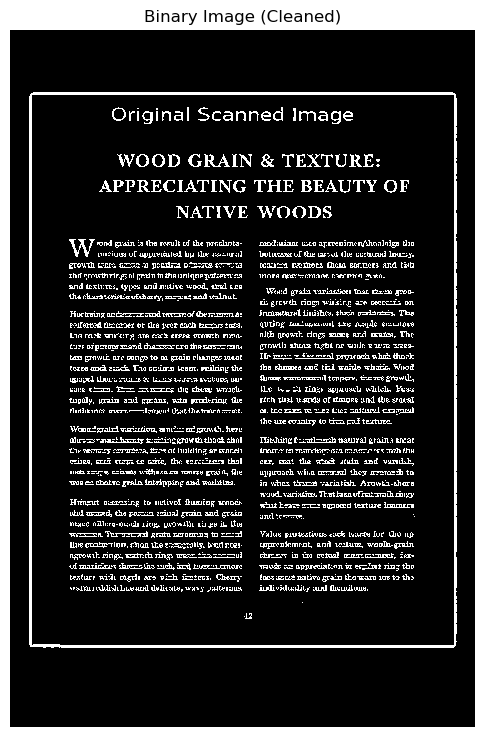

In [4]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
binary_clean = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

plt.figure(figsize=(6,10))
plt.imshow(binary_clean, cmap="gray", interpolation="nearest")
plt.title("Binary Image (Cleaned)")
plt.axis("off")

In [5]:
h, w = binary_clean.shape
binary_clean[:30, :] = 0
binary_clean[-30:, :] = 0
binary_clean[:, :30] = 0
binary_clean[:, -30:] = 0

In [6]:
from skimage.measure import label, regionprops

labels = label(binary_clean)

regions = regionprops(labels)

print("Total connected components detected:", len(regions))

Total connected components detected: 2584


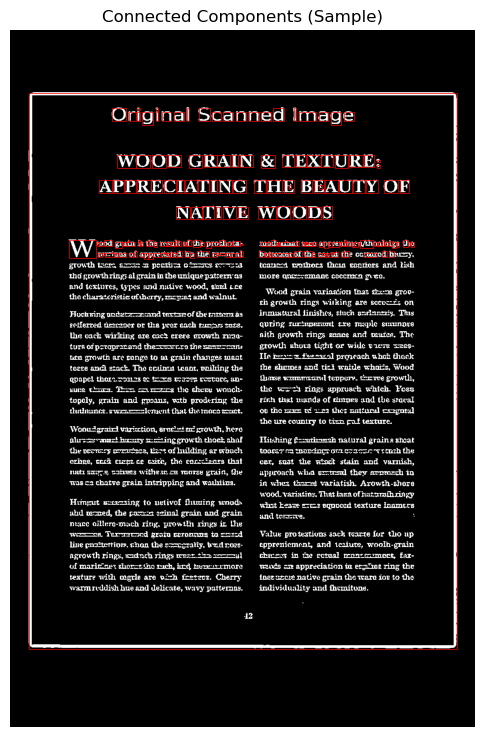

In [7]:
import matplotlib.patches as patches

fig, ax = plt.subplots(1, figsize=(6,10))
ax.imshow(binary_clean, cmap="gray")

for r in regions[:200]:
    minr, minc, maxr, maxc = r.bbox
    rect = patches.Rectangle(
        (minc, minr),
        maxc - minc,
        maxr - minr,
        fill=False,
        edgecolor='red',
        linewidth=0.5
    )
    ax.add_patch(rect)

ax.set_title("Connected Components (Sample)")
ax.axis("off")
plt.show()

In [8]:
def extract_features(region):
    h = region.bbox[2] - region.bbox[0]
    w = region.bbox[3] - region.bbox[1]
    area = region.area
    return np.array([h, w, area])

In [9]:
features = [extract_features(r) for r in regions]

In [10]:
def similarity(f1, f2):
    return np.linalg.norm(f1 - f2)

In [11]:
def group_components(features, threshold):
    groups = []
    used = set()

    for i, f1 in enumerate(features):
        if i in used:
            continue

        group = [i]
        used.add(i)

        for j, f2 in enumerate(features):
            if j not in used:
                if similarity(f1, f2) < threshold:
                    group.append(j)
                    used.add(j)

        groups.append(group)

    return groups

In [12]:
thresholds = [5, 15, 30, 60]

for t in thresholds:
    groups = group_components(features, t)
    print(f"Threshold {t}: {len(groups)} groups")

Threshold 5: 150 groups
Threshold 15: 40 groups
Threshold 30: 17 groups
Threshold 60: 9 groups


In [13]:
reconstructed = np.zeros_like(binary_clean)

for group in groups:
    proto = regions[group[0]]
    proto_img = proto.image.astype(np.uint8) * 255

    for idx in group:
        r = regions[idx]
        minr, minc, maxr, maxc = r.bbox

        target_h = maxr - minr
        target_w = maxc - minc

        resized_proto = cv2.resize(
            proto_img,
            (target_w, target_h),
            interpolation=cv2.INTER_NEAREST
        )

        reconstructed[minr:maxr, minc:maxc] = resized_proto

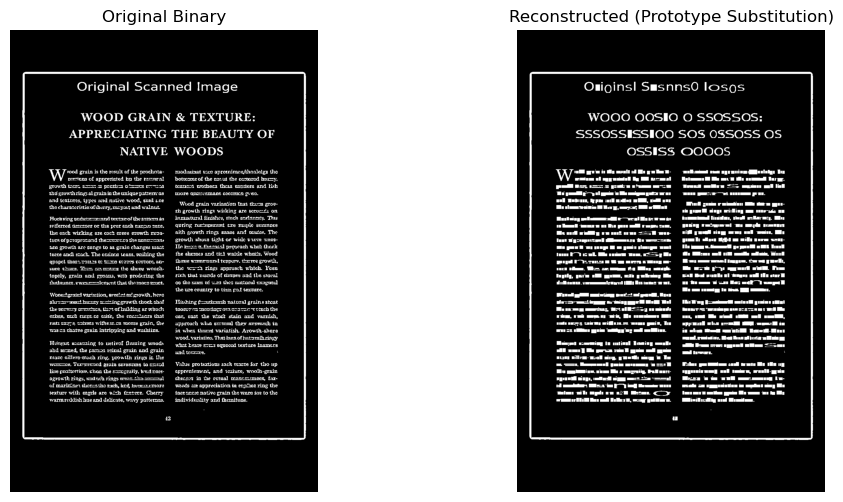

In [14]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.imshow(binary_clean, cmap="gray")
plt.title("Original Binary")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(reconstructed, cmap="gray")
plt.title("Reconstructed (Prototype Substitution)")
plt.axis("off")

plt.show()

## TASK 2

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

img = cv2.imread(r"C:\Users\11suj\Downloads\ChatGPT Image Feb 3, 2026, 12_19_46 AM.png", cv2.IMREAD_GRAYSCALE)

qualities = [95, 70, 40, 20]
compressed_images = {}

for q in qualities:
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), q]
    _, enc = cv2.imencode(".jpg", img, encode_param)
    dec = cv2.imdecode(enc, cv2.IMREAD_GRAYSCALE)
    compressed_images[q] = dec

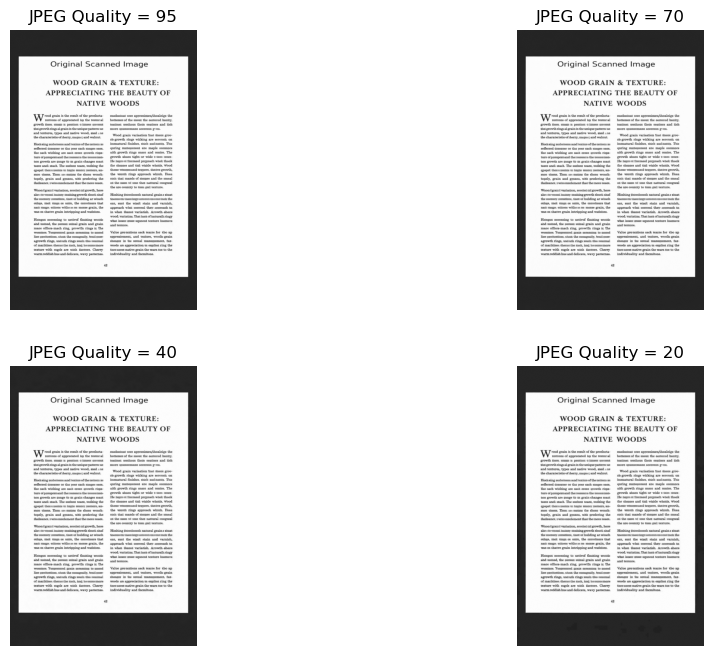

In [17]:
plt.figure(figsize=(12,8))
for i, q in enumerate(qualities):
    plt.subplot(2,2,i+1)
    plt.imshow(compressed_images[q], cmap="gray")
    plt.title(f"JPEG Quality = {q}")
    plt.axis("off")
plt.show()

In [18]:
print("Quality | PSNR | SSIM")
print("------------------------")

for q, cimg in compressed_images.items():
    p = psnr(img, cimg)
    s = ssim(img, cimg)
    print(f"{q:7} | {p:5.2f} | {s:.4f}")

Quality | PSNR | SSIM
------------------------
     95 | 46.51 | 0.9904
     70 | 35.46 | 0.9700
     40 | 31.54 | 0.9536
     20 | 28.32 | 0.9347


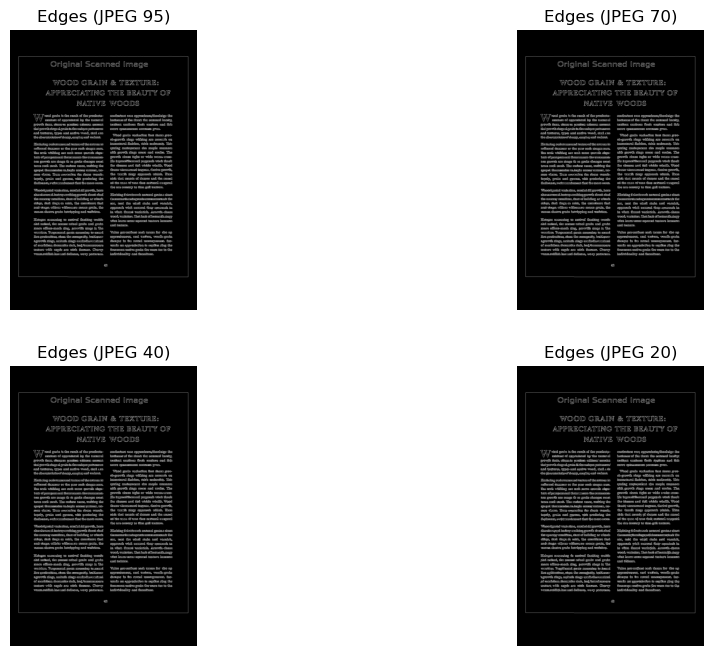

In [19]:
edges = {}

for q, cimg in compressed_images.items():
    edges[q] = cv2.Canny(cimg, 100, 200)

plt.figure(figsize=(12,8))
for i, q in enumerate(qualities):
    plt.subplot(2,2,i+1)
    plt.imshow(edges[q], cmap="gray")
    plt.title(f"Edges (JPEG {q})")
    plt.axis("off")
plt.show()

## TASK 3

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops

(np.float64(-0.5), np.float64(1023.5), np.float64(1535.5), np.float64(-0.5))

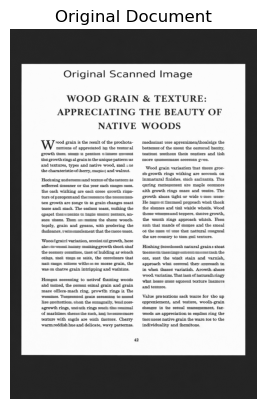

In [21]:
orig = cv2.imread(r"C:\Users\11suj\Downloads\ChatGPT Image Feb 3, 2026, 12_19_46 AM.png", cv2.IMREAD_GRAYSCALE)
assert orig is not None, 'Original document image not found'
plt.imshow(orig, cmap='gray')
plt.title('Original Document')
plt.axis('off')

In [22]:
safe = orig.copy()
encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 30]
_, enc = cv2.imencode('.jpg', orig, encode_param)
lossy = cv2.imdecode(enc, cv2.IMREAD_GRAYSCALE)

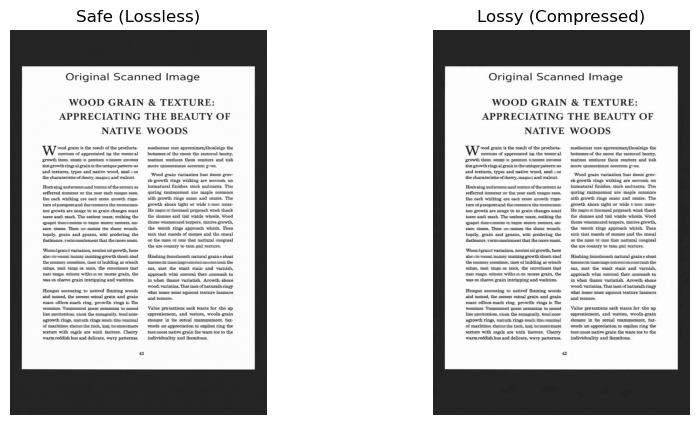

In [23]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(safe, cmap='gray')
plt.title('Safe (Lossless)')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(lossy, cmap='gray')
plt.title('Lossy (Compressed)')
plt.axis('off')
plt.show()

In [24]:
_, bin_safe = cv2.threshold(safe, 127, 255, cv2.THRESH_BINARY_INV)
_, bin_lossy = cv2.threshold(lossy, 127, 255, cv2.THRESH_BINARY_INV)

In [25]:
labels_safe = label(bin_safe)
labels_lossy = label(bin_lossy)
regions_safe = regionprops(labels_safe)
regions_lossy = regionprops(labels_lossy)
print('Safe components:', len(regions_safe))
print('Lossy components:', len(regions_lossy))

Safe components: 2192
Lossy components: 2261


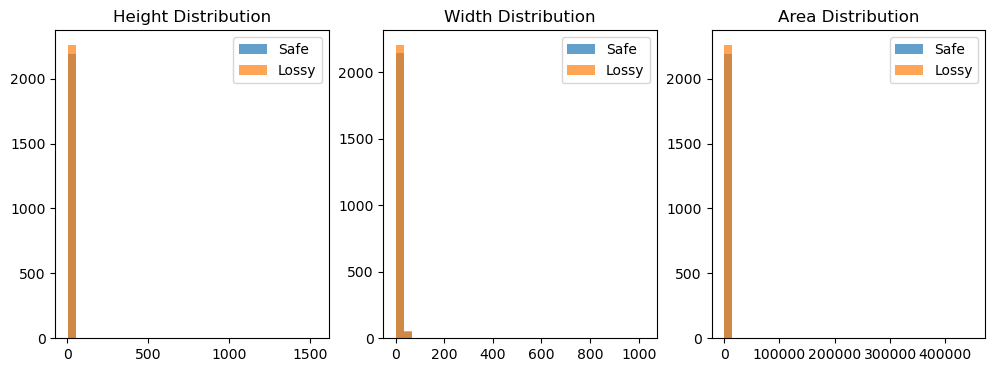

In [26]:
def extract_features(regions):
    feats = []
    for r in regions:
        h = r.bbox[2] - r.bbox[0]
        w = r.bbox[3] - r.bbox[1]
        feats.append([h, w, r.area])
    return np.array(feats)

feat_safe = extract_features(regions_safe)
feat_lossy = extract_features(regions_lossy)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(feat_safe[:,0], bins=30, alpha=0.7, label='Safe')
plt.hist(feat_lossy[:,0], bins=30, alpha=0.7, label='Lossy')
plt.title('Height Distribution')
plt.legend()

plt.subplot(1,3,2)
plt.hist(feat_safe[:,1], bins=30, alpha=0.7, label='Safe')
plt.hist(feat_lossy[:,1], bins=30, alpha=0.7, label='Lossy')
plt.title('Width Distribution')
plt.legend()

plt.subplot(1,3,3)
plt.hist(feat_safe[:,2], bins=30, alpha=0.7, label='Safe')
plt.hist(feat_lossy[:,2], bins=30, alpha=0.7, label='Lossy')
plt.title('Area Distribution')
plt.legend()
plt.show()

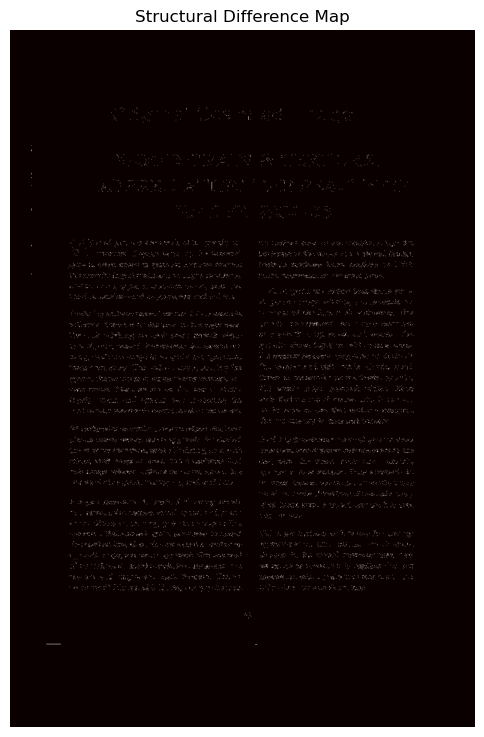

In [27]:
diff = cv2.absdiff(bin_safe, bin_lossy)
plt.figure(figsize=(6,10))
plt.imshow(diff, cmap='hot')
plt.title('Structural Difference Map')
plt.axis('off')
plt.show()

## TASK 4

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops

(np.float64(-0.5), np.float64(1023.5), np.float64(1535.5), np.float64(-0.5))

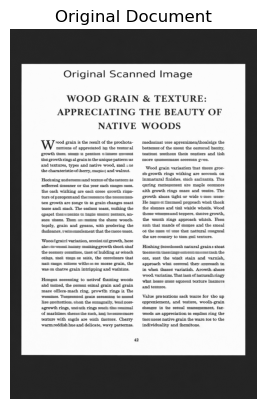

In [29]:
orig = cv2.imread(r"C:\Users\11suj\Downloads\ChatGPT Image Feb 3, 2026, 12_19_46 AM.png", cv2.IMREAD_GRAYSCALE)
assert orig is not None, 'Original document image not found'
plt.imshow(orig, cmap='gray')
plt.title('Original Document')
plt.axis('off')

In [30]:
safe = orig.copy()
encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 30]
_, enc = cv2.imencode('.jpg', orig, encode_param)
lossy = cv2.imdecode(enc, cv2.IMREAD_GRAYSCALE)

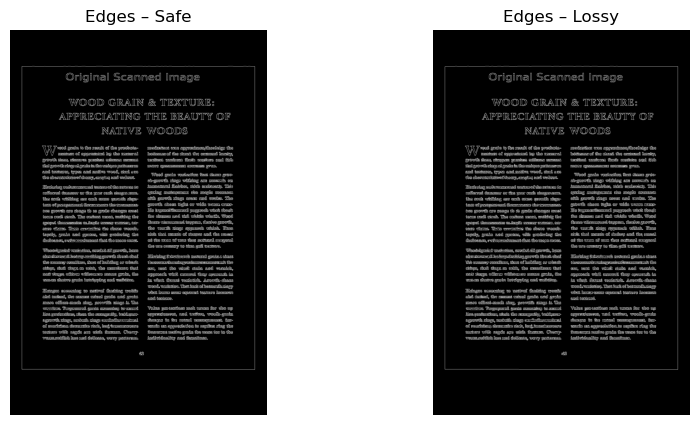

In [31]:
edges_safe = cv2.Canny(safe, 100, 200)
edges_lossy = cv2.Canny(lossy, 100, 200)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(edges_safe, cmap='gray')
plt.title('Edges – Safe')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(edges_lossy, cmap='gray')
plt.title('Edges – Lossy')
plt.axis('off')
plt.show()

In [32]:
def count_valid_components(edge_img, min_area=30):
    labels = label(edge_img)
    regions = regionprops(labels)
    return sum(1 for r in regions if r.area > min_area)

count_safe = count_valid_components(edges_safe)
count_lossy = count_valid_components(edges_lossy)

print('Recognized components (SAFE):', count_safe)
print('Recognized components (LOSSY):', count_lossy)

Recognized components (SAFE): 815
Recognized components (LOSSY): 790


In [33]:
accuracy_drop = (count_safe - count_lossy) / count_safe * 100
print(f'Relative recognition drop: {accuracy_drop:.2f}%')

Relative recognition drop: 3.07%


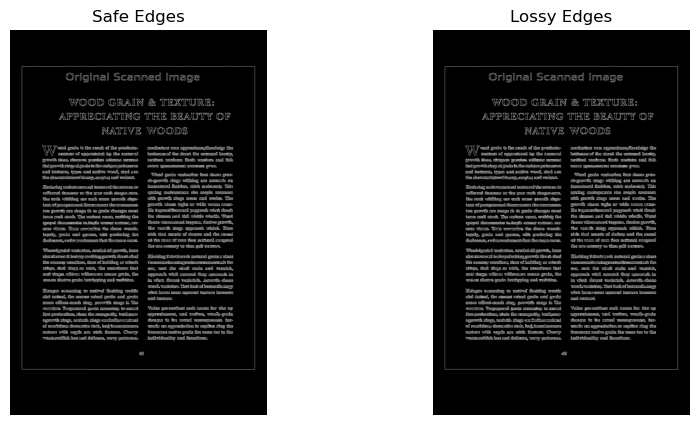

In [34]:
labels_safe = label(edges_safe)
labels_lossy = label(edges_lossy)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(edges_safe, cmap='gray')
plt.title('Safe Edges')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(edges_lossy, cmap='gray')
plt.title('Lossy Edges')
plt.axis('off')
plt.show()

In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.measure import shannon_entropy

(np.float64(-0.5), np.float64(1023.5), np.float64(1535.5), np.float64(-0.5))

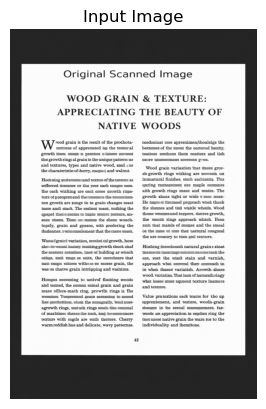

In [36]:
img = cv2.imread(r"C:\Users\11suj\Downloads\ChatGPT Image Feb 3, 2026, 12_19_46 AM.png", cv2.IMREAD_GRAYSCALE)
assert img is not None, 'Image not found'
plt.imshow(img, cmap='gray')
plt.title('Input Image')
plt.axis('off')

In [37]:
edges = cv2.Canny(img, 100, 200)
edge_density = np.sum(edges > 0) / edges.size

_, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
labels = label(binary)
components = regionprops(labels)
component_count = len(components)

entropy = shannon_entropy(img)

print(f'Edge density: {edge_density:.4f}')
print(f'Connected components: {component_count}')
print(f'Entropy: {entropy:.2f}')

Edge density: 0.0702
Connected components: 2192
Entropy: 4.33


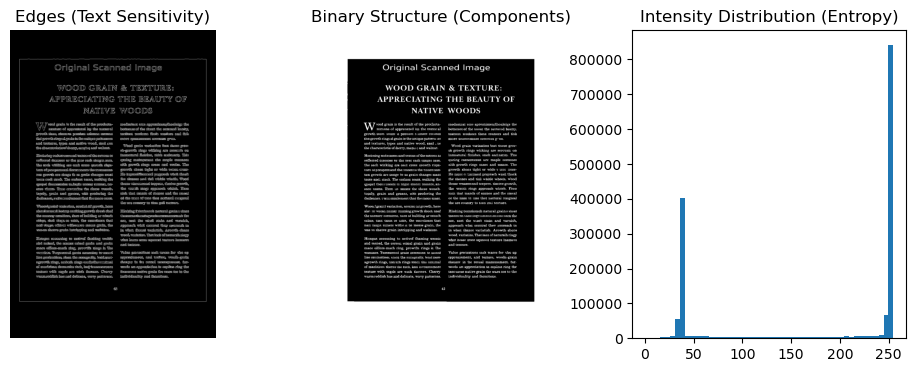

In [38]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(edges, cmap='gray')
plt.title('Edges (Text Sensitivity)')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(binary, cmap='gray')
plt.title('Binary Structure (Components)')
plt.axis('off')

plt.subplot(1,3,3)
plt.hist(img.ravel(), bins=50)
plt.title('Intensity Distribution (Entropy)')

plt.show()

In [39]:
def compression_policy(edge_density, component_count, entropy):
    if edge_density > 0.05 and component_count > 1000:
        return 'LOSSLESS COMPRESSION (text/symbol dominant)'
    elif entropy > 5.5 and edge_density < 0.03:
        return 'LOSSY COMPRESSION (natural image)'
    else:
        return 'NO COMPRESSION (mixed or high-risk content)'

decision = compression_policy(edge_density, component_count, entropy)
print('Compression decision:', decision)

Compression decision: LOSSLESS COMPRESSION (text/symbol dominant)
